In [2]:
# main libs
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
import mne

# graphical libs
from matplotlib import pyplot as plt

#%matplotlib widget


# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# ml libraries
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler #, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, AdaBoostClassifier

import optuna
from optuna.samplers import TPESampler

# set number of rows ti display
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output

In [3]:
# Set requirements
#!pip install -qr ../requirements.txt

In [4]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.functions import config_reader
from utils.figures import get_all_sensors_plot, get_sensor_command_plot

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [5]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in tensorflow 
#tf.random.set_seed(seed_value)

# 4. initiate random seed in Optuna
sampler = TPESampler(seed=seed_value) # fix random seed

Задача: регрессионный анализ координат пальцев протеза по показаниям от датчиков ОМГ.

* X_train.npy - обучающая выборка имеющая размерности  
* X_test.npy - тестоваая выборка имеющая размерности  
* y_train.npy - целевая переменная для обучающей выборки 

 


In [6]:
# Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
mounts = dict()

with ZipFile(os.path.join(PATH, 'test_task.zip')) as myzip:
    for file in myzip.namelist():
        if file[-3:] == 'npy':
            mounts[f"{file[:-4]}".format(file)] = np.load(myzip.open(file))
        elif file[-3:] == 'csv':
            mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file))
        else:
            pass

mounts.keys()

dict_keys(['X_test', 'X_train', 'sample_submission', 'y_train'])

In [7]:
# read files 
    
X_train,  = mounts['X_train']
X_test  = mounts['X_test']

y_train = mounts['y_train']
y_test  = mounts['sample_submission']
    
print(f"Размерность файла 'X_train': {X_train.shape}. Размерность: наблюдения, датчики, время")
print(f"Размерность файла 'X_test ': {X_test.shape}. Размерность: наблюдения, датчики, время")
print(f"Размерность файла 'y_train': {y_train.shape}. Размерность: наблюдения, время")

Размерность файла 'X_train': (323, 40, 100). Размерность: наблюдения, датчики, время
Размерность файла 'X_test ': (54, 40, 100). Размерность: наблюдения, датчики, время
Размерность файла 'y_train': (32300, 2). Размерность: наблюдения, время


In [8]:
get_sensor_command_plot(2, X_train, y_train['class'])  , plot_counter=1

In [9]:
y_train[['sample_id', 'timestep']] = y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)
y_train = y_train.pivot(index='sample_id', columns='timestep', values='class')
y_train_index = y_train.index
y_train = y_train.sort_index() # на всякий случай
y_train = y_train.values

print(y_train.shape)

y_train 

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

Файл y_train содержит классы переменной

In [10]:
df_y_train = []
for idx, arr in zip(y_train_index, y_train):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    df_y_train.append(series)
    
df_y_train = pd.concat(df_y_train)
df_y_train = df_y_train.reset_index()
df_y_train.columns = ["sample-timestep", "class"]
df_y_train['open_hand'] = df_y_train['class'].apply(lambda x: 1 if x == 0 else 0)
df_y_train

,sample-timestep,class,open_hand
0,0-0,0,1
1,0-1,0,1
2,0-2,0,1
3,0-3,0,1
...,...,...,...
32296,322-96,4,0
32297,322-97,4,0
32298,322-98,4,0
32299,322-99,4,0


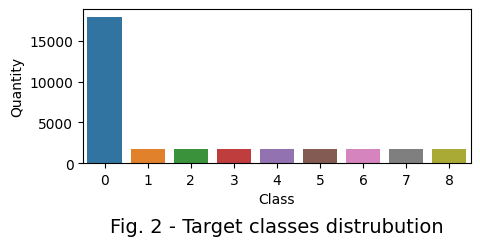

In [11]:
# построим график распределения классов
y_counts = df_y_train['class'].value_counts()

fig_id = 2
fig, ax = plt.subplots(figsize=(5, 2)) 
fig = sns.barplot(data = df_y_train, x = y_counts.index, y = y_counts)
fig.set_title(f'Fig. {fig_id} - Target classes distrubution', y=-0.5, fontsize=14)
fig.set_xlabel('Class')
fig.set_ylabel('Quantity');

Класс 0 заметно превосходит по количеству все остальные.

## Reshaping

In [15]:
# X_train_flat = pd.DataFrame(np.transpose(X_train,(0,2,1)).reshape(32300, -1).astype(int))
# X_train_flat.tail()

,0,1,2,3,...,36,37,38,39
32295,1679,17,1826,36,...,1689,25,388,27
32296,1673,4,1827,35,...,1690,32,388,27
32297,1669,10,1832,33,...,1690,16,390,27
32298,1670,3,1831,36,...,1691,29,391,4
32299,1666,8,1829,36,...,1691,22,398,26


In [17]:
print(y_train.shape)
y_train[2]

(323, 100)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64)

## Scaling

In [18]:
# Scaling the Train and Test feature set 
 
scaler = MinMaxScaler() #StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_flat.columns)

# Model training

In [19]:
def stratified_cross_valid(model: LogisticRegression, 
                           X_train: pd.DataFrame, y_train: pd.Series, 
                           n: int, metric: str) -> None:
    """
    Функция оценки модели на кросс-валидации: вывод графика с результатами 
    кросс-валидации, кривой достаточности данных и таблицы с результатами
    """
    print(model)
    cv_splitter = StratifiedKFold(n_splits = n)
    
    metric_table = pd.DataFrame()

    i = 0
                    
    cv_res = cross_validate(
        model, 
        X_train, 
        y_train, 
        scoring = metric, 
        n_jobs = -1, 
        cv = cv_splitter, 
        return_train_score = True, 
        verbose = 0)

    cv_train = cv_res['train_score'].mean()
    cv_test = cv_res['test_score'].mean()


    metric_table.loc[i, 'cv_train'] = cv_train
    metric_table.loc[i, 'cv_test'] = cv_test

                    
    metric_table['cv_dif'] = metric_table['cv_train'] - metric_table['cv_test']

    #результаты кросс-валидации
    fig, ax = plt.subplots(1,2, figsize=(10, 3)) 
    sns.pointplot(x=np.arange(n)+1, y=cv_res['train_score'], color = 'r', ax=ax[0])
    sns.pointplot(x=np.arange(n)+1, y=cv_res['test_score'], color = 'g', ax=ax[0])
    ax[0].set_title('Результаты кросс-валидации', fontsize=14)
    ax[0].set_xlabel('Порядковый номер части совокупности')
    ax[0].set_ylabel('Показатель качества модели\n f-score')
    ax[0].set_ylim(0.4, 1.1)
    ax[0].grid() # показать сетку
    #plt.show()

    # кривая обучения
    result = []

    s = len(X_train)
    p = len(X_train) // (n + 1)
    for i in np.arange(p, s - p + 1, p):
        model.fit(X_train.iloc[:i], y_train.iloc[:i].values.ravel())  # + .values.ravel()
        predict = model.predict(X_train.iloc[i:i+p])
        res = f1_score(y_train.iloc[i:i+p], predict, average='macro')
        result.append(res)

    sns.pointplot(x=np.arange(n)+1, y=result, ax=ax[1])
    ax[1].set_title('Кривая обучения', fontsize=14)
    ax[1].set_xlabel('Порядковый номер части совокупности')
    ax[1].set_ylabel('Показатель качества  модели\n f-score')
    ax[1].set_ylim(0.4, 1.05)
    ax[1].grid(); # показать сетку
    #plt.tight_layout()
    #plt.show()
    print()
    
    print(metric_table.sort_values(by ='cv_test').round(2))
    print()

In [20]:
# Dict to store models
models_dict = dict()

LogisticRegression(C=0.8,
                   class_weight={0: 0.7, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1,
                                 7: 1, 8: 1},
                   multi_class='multinomial', random_state=0, solver='saga')

   cv_train  cv_test  cv_dif
0       0.8     0.76    0.03



StratifiedKFold(n_splits=6, random_state=None, shuffle=False)

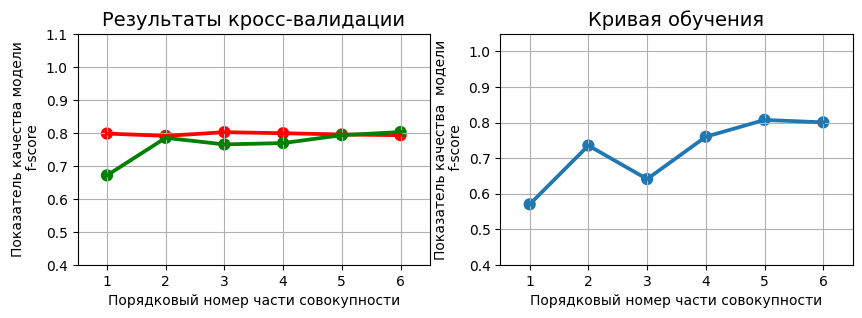

In [21]:
# Уравновешивание классов 
weights = {0:0.7, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:1, 8:1}

logreg = LogisticRegression(
    solver='saga',   # 'liblinear' 'saga' 'newton-cg' 
    random_state=seed_value, 
    multi_class='multinomial',
    C=0.8, #  1, 10, 100, 500
    class_weight=weights,
    #penalty='l1' #'l1', 'l2', 'elasticnet'
)

stratified_cross_valid(logreg, X_train_scaled, df_y_train['class'], 6, 'f1_macro') 

cv_splitter = StratifiedKFold(n_splits = 6)
display(cv_splitter);

# Submission

In [90]:
# загружаем пример sample_submission
y_test = mounts['sample_submission']
y_test

,sample-timestep,class
0,323-0,0
1,323-1,7
2,323-2,3
3,323-3,0
...,...,...
5396,376-96,1
5397,376-97,0
5398,376-98,5
5399,376-99,1


In [ ]:
# recovering saved model
with open(config.path_models + models_dict['...'] + '.pkl', 'rb') as f: 
    model_xxx = pickle.load(f)

In [ ]:
y_pred = model_xxx.predict(X_test_scaled) # можно взять из словаря

print(y_pred.shape)
y_pred

In [34]:
y_test['class'] = y_pred
y_test.to_csv('submission.csv', index=False)
y_test

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
...,...,...
5396,376-96,4
5397,376-97,4
5398,376-98,4
5399,376-99,4
